In [1]:
# imports

import random
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import patches
from torch.utils.data import random_split
from torchvision import transforms

torch.manual_seed(265)
torch.set_default_dtype(torch.double)

In [2]:
path = 'datasets/'
train_path = path + 'localization_test.pt'
val_path = path + 'localization_val.pt'
test_path = path + 'localization_test.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model parameters
EPOCHS = 20  # Epochs
BATCH_SIZE = 64  # Batch size
KEEP_PROB = 1  # Dropout

#Optimizer parameters
LR = 1e-2  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-4  # L2 Regularization

models = []
model_names = []
loss_train_list = []
loss_val_list = []

In [3]:
train_data = torch.load(train_path)
val_data = torch.load(val_path)
test_data = torch.load(test_path)

In [4]:
# Train normalization
train_all = [x for x, _ in train_data]
trainto_one_tensor = torch.stack(train_all)

mean = trainto_one_tensor.mean()
std = trainto_one_tensor.std()

train_data_n = train_data
train_data.transform = transforms.Normalize(mean, std)

# Val normalization
val_all = [x for x, _ in val_data]
val_to_one_tensor = torch.stack(val_all)

mean = val_to_one_tensor.mean()
std = val_to_one_tensor.std()

val_data_n = val_data
val_data_n.transform = transforms.Normalize(mean, std)

# Test normalization
test_all = [x for x, _ in test_data]
test_to_one_tensor = torch.stack(test_all)

mean = test_to_one_tensor.mean()
std = test_to_one_tensor.std()

test_data_n = test_data
test_data_n.transform = transforms.Normalize(mean, std)

In [5]:
def print_random_img(data):
    x, y = data.__getitem__(random.randint(0, len(data)))
    tensor_image = transforms.ToPILImage()(x).convert("RGB")
    plt.imshow(tensor_image)
    plt.show()

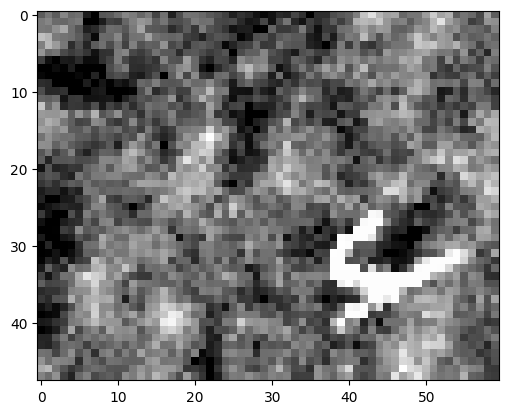

In [6]:
print_random_img(train_data)

Standard LeNet5 Model:

In [7]:
class Net01(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Linear(in_features=9 * 12 * 16, out_features=120),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.fc5 = nn.Linear(in_features=84, out_features=15)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = y.view(y.shape[0], -1)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.fc5(y)

        return y

Shallow LeNet5 Model:

In [8]:
class Net02(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Linear(in_features=9 * 12 * 8, out_features=84),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.fc4 = nn.Linear(in_features=84, out_features=15)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = y.view(y.shape[0], -1)
        y = self.layer3(y)
        y = self.fc4(y)

        return y

Deep LeNet5 Model:

In [9]:
class Net03(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Linear(in_features=9 * 12 * 32, out_features=240),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Linear(in_features=240, out_features=168),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer5 = torch.nn.Sequential(
            nn.Linear(in_features=168, out_features=84),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.fc6 = nn.Linear(in_features=84, out_features=15)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = y.view(y.shape[0], -1)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = self.fc6(y)

        return y

Custom loss function:

In [10]:
def myLoss(output, target):
    # Uses BinaryClassification as a  loss function to train the network to recognize if there is a number in the cell or not
    prob = output[:, :1]
    probTarget = target[:, :1]
    loss_fn = nn.BCEWithLogitsLoss()
    loss_prob = loss_fn(prob, probTarget)

    # Creates boolean mask based of if there is a number in the cell and filters out all labels where there is no number
    outputShape = output.shape[1]
    maskOutput = target[:, :1].eq(1).repeat(1, outputShape)
    maskTarget = target[:, :1].eq(1).repeat(1, 6)
    output = torch.masked_select(output, maskOutput)
    target = torch.masked_select(target, maskTarget)
    output = output.reshape(int(output.shape[0] / outputShape), outputShape)
    target = target.reshape(int(target.shape[0] / 6), 6)

    # If there is a number ni the cell it uses MeanSquaredError as a loss function to train the network to find the number's center and its bounding box
    bb = output[:, 1:5]
    bbTarget = target[:, 1:5].to(dtype=torch.double)
    loss_fn = nn.MSELoss()
    loss_bb = loss_fn(bb, bbTarget)

    # If there is a number in the cell it uses CrossEntropy as a loss function to train the network to classify the numbers
    clas = output[:, 5:]
    clasTarget = target[:, 5].to(dtype=torch.long)
    loss_fn = nn.CrossEntropyLoss()
    loss_clas = loss_fn(clas, clasTarget)

    return loss_prob + loss_bb + loss_clas

In [11]:
def train(n_epochs, optimizer, model, train_loader, train_mode):
    """
    Train our model and save weight values
    """
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)

            outputs = model(imgs)

            loss = myLoss(outputs, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
    train_mode.append(losses_train)

In [12]:
train_loader = torch.utils.data.DataLoader(train_data_n, batch_size=BATCH_SIZE, shuffle=True)
model01 = Net01().to(device=device)
optimizer = optim.Adam(model01.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model01, train_loader, loss_train_list)
models.append(model01)
model_names.append("LeNet Standard")

17:50:47.127798  |  Epoch 1  |  Training loss 2.39718
17:50:54.965426  |  Epoch 2  |  Training loss 2.33537
17:51:02.317176  |  Epoch 3  |  Training loss 2.33053
17:51:09.700542  |  Epoch 4  |  Training loss 2.32760
17:51:17.199959  |  Epoch 5  |  Training loss 2.32775
17:51:25.123504  |  Epoch 6  |  Training loss 2.32736
17:51:32.560402  |  Epoch 7  |  Training loss 2.32769
17:51:39.805631  |  Epoch 8  |  Training loss 2.32508
17:51:46.848763  |  Epoch 9  |  Training loss 2.32653
17:51:54.050367  |  Epoch 10  |  Training loss 2.32608
17:52:01.090044  |  Epoch 11  |  Training loss 2.32668
17:52:08.216076  |  Epoch 12  |  Training loss 2.32472
17:52:15.386721  |  Epoch 13  |  Training loss 2.32624
17:52:22.511715  |  Epoch 14  |  Training loss 2.32539
17:52:29.360131  |  Epoch 15  |  Training loss 2.32434
17:52:36.161498  |  Epoch 16  |  Training loss 2.32450
17:52:43.013432  |  Epoch 17  |  Training loss 2.32499
17:52:49.741504  |  Epoch 18  |  Training loss 2.32534
17:52:56.508473  | 

In [13]:
train_loader = torch.utils.data.DataLoader(train_data_n, batch_size=BATCH_SIZE, shuffle=True)
model02 = Net02().to(device=device)
optimizer = optim.Adam(model02.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model02, train_loader, loss_train_list)
models.append(model02)
model_names.append("LeNet Shallow")

17:53:07.266514  |  Epoch 1  |  Training loss 2.37788
17:53:11.139807  |  Epoch 2  |  Training loss 2.31931
17:53:15.049907  |  Epoch 3  |  Training loss 2.33048
17:53:18.940470  |  Epoch 4  |  Training loss 2.32973
17:53:22.824207  |  Epoch 5  |  Training loss 2.32993
17:53:26.711611  |  Epoch 6  |  Training loss 2.32883
17:53:30.621602  |  Epoch 7  |  Training loss 2.32814
17:53:34.502379  |  Epoch 8  |  Training loss 2.32742
17:53:38.388292  |  Epoch 9  |  Training loss 2.31409
17:53:42.263491  |  Epoch 10  |  Training loss 2.23112
17:53:46.171677  |  Epoch 11  |  Training loss 2.07783
17:53:50.077470  |  Epoch 12  |  Training loss 1.98478
17:53:53.976755  |  Epoch 13  |  Training loss 1.88831
17:53:57.891107  |  Epoch 14  |  Training loss 1.82057
17:54:01.842772  |  Epoch 15  |  Training loss 1.76826
17:54:05.744090  |  Epoch 16  |  Training loss 1.73418
17:54:09.630587  |  Epoch 17  |  Training loss 1.70306
17:54:13.534057  |  Epoch 18  |  Training loss 1.65462
17:54:17.434464  | 

In [14]:
train_loader = torch.utils.data.DataLoader(train_data_n, batch_size=BATCH_SIZE, shuffle=True)
model03 = Net03().to(device=device)
optimizer = optim.Adam(model03.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model03, train_loader, loss_train_list)
models.append(model03)
model_names.append("LeNet Deep")

17:54:44.428994  |  Epoch 1  |  Training loss 2.56227
17:55:09.556623  |  Epoch 2  |  Training loss 2.33386
17:55:31.986512  |  Epoch 3  |  Training loss 2.33169
17:55:53.999995  |  Epoch 4  |  Training loss 2.32846
17:56:15.755542  |  Epoch 5  |  Training loss 2.32843
17:56:37.275480  |  Epoch 6  |  Training loss 2.32712
17:56:59.055557  |  Epoch 7  |  Training loss 2.32684
17:57:21.834659  |  Epoch 8  |  Training loss 2.32706
17:57:43.413918  |  Epoch 9  |  Training loss 2.32699
17:58:05.185354  |  Epoch 10  |  Training loss 2.32652
17:58:26.821330  |  Epoch 11  |  Training loss 2.32661
17:58:48.767192  |  Epoch 12  |  Training loss 2.32543
17:59:10.651236  |  Epoch 13  |  Training loss 2.32596
17:59:32.769183  |  Epoch 14  |  Training loss 2.32516
17:59:54.787094  |  Epoch 15  |  Training loss 2.32459
18:00:16.828051  |  Epoch 16  |  Training loss 2.32480
18:00:38.268495  |  Epoch 17  |  Training loss 2.32512
18:00:59.799250  |  Epoch 18  |  Training loss 2.32461
18:01:21.331481  | 

In [15]:
def intersection_over_union(pred_box: torch.tensor, label_box: torch.tensor):
    box1_x1 = pred_box[..., 0:1] - pred_box[..., 2:3] / 2
    box1_y1 = pred_box[..., 1:2] - pred_box[..., 3:4] / 2
    box1_x2 = pred_box[..., 0:1] + pred_box[..., 2:3] / 2
    box1_y2 = pred_box[..., 1:2] + pred_box[..., 3:4] / 2

    box2_x1 = label_box[..., 0:1] - label_box[..., 2:3] / 2
    box2_y1 = label_box[..., 1:2] - label_box[..., 3:4] / 2
    box2_x2 = label_box[..., 0:1] + label_box[..., 2:3] / 2
    box2_y2 = label_box[..., 1:2] + label_box[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [16]:
def find_highest_acc(output):
    output = output.squeeze()
    classes = [x.item() for x in output]
    classes = classes[5:]
    index = (classes.index(max(classes)))
    return index


def get_vals(tensor: torch.tensor):
    """
    :param tensor:
    :return x, y, w, h:
    """
    tens = tensor[0][1:5].clone().detach()
    return torch.tensor(
        [(int(tens[0] * 60)) - int((tens[2] / 2) * 60),
         int(tens[1] * 48) - int((tens[3] / 2) * 48),
         int(tens[2] * 60),
         int(tens[3] * 48)],
        dtype=torch.int)


def compute_acc(model, loader):
    correct = 0.
    total = 0.
    IoU = 0
    with torch.no_grad():
        model.eval()
        for imgs, labels in loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)
            output = model(imgs)
            IoU += intersection_over_union(get_vals(labels), get_vals(output))
            output = output.squeeze()
            output[5:] = torch.nn.functional.softmax(output[5:].clone(), dim=0)
            true_class = int(labels[0][-1].item())
            predicted_class = find_highest_acc(output)
            if true_class == predicted_class:
                correct += 1
                total += 1
            else:
                total += 1

    return ((correct + IoU) / total).item()

In [17]:
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.unsqueeze(dim=1)
    labels = outputs.unsqueeze(dim=1)
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

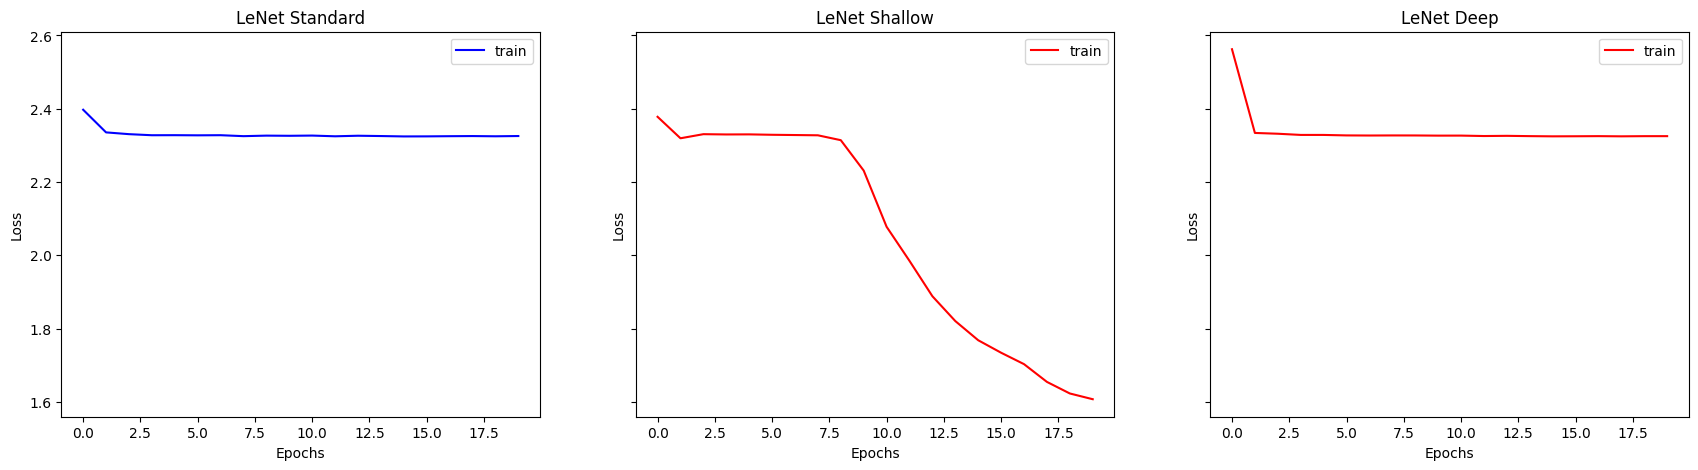

In [18]:
n_model = len(models)

fig, axes = plt.subplots(1, n_model, figsize=(7 * n_model, 5), sharey=True, squeeze=False)

for l_train, name, ax in zip(loss_train_list, model_names, axes.flat):
    ax.plot(l_train, label='train', color=random.choice(['r', 'b', 'y', 'g', 'c', 'm']))
    ax.set_title(str(name))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

Best model is:

In [19]:
model_score = []
for i, model in enumerate(models):
    val_loader = torch.utils.data.DataLoader(val_data_n, shuffle=False)
    model_perf = compute_acc(model, val_loader) * 100
    model_score.append(model_perf)
    print(f"Accuracy of {model_names[i]} is {model_perf}")

index_best_model = (model_score.index(max(model_score)))
best_model = models[index_best_model]
print(f"The best model is {model_names[index_best_model]}")

Accuracy of LeNet Standard is 23.594110590002963
Accuracy of LeNet Shallow is 60.59473741858164
Accuracy of LeNet Deep is 23.594110590002963
The best model is LeNet Shallow


In [20]:
def draw_bounding_box_man(pan, true_tup, pred_tup, true_w, pred_w, true_h, pred_h):
    fig, ax = plt.subplots(1)
    ax.imshow(pan)
    true_x = true_tup[0]
    true_y = true_tup[1]
    true_bb = patches.Rectangle((true_x, true_y), true_w, true_h, linewidth=3, edgecolor='r',
                                facecolor='none')
    pred_bb = patches.Rectangle((pred_tup[0], pred_tup[1]), pred_w, pred_h, linewidth=3, edgecolor='b',
                                facecolor='none')

    ax.add_patch(true_bb)
    ax.add_patch(pred_bb)

    plt.show()

Intersection over union is: 63.95147302608064


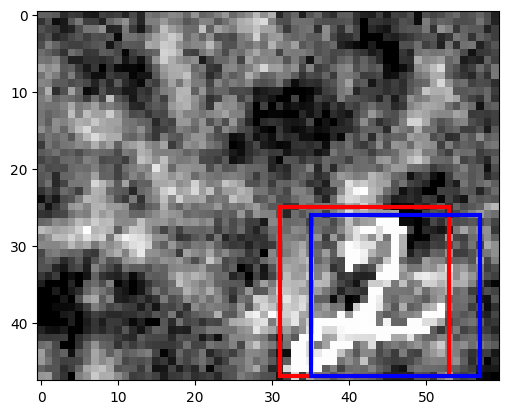

Correct label is: 2
The model prediction is: 2
Confidence: 16.2766 % for element 0
Confidence: 0.0574 % for element 1
Confidence: 48.5254 % for element 2
Confidence: 3.3472 % for element 3
Confidence: 3.8875 % for element 4
Confidence: 7.4259 % for element 5
Confidence: 12.1274 % for element 6
Confidence: 0.5205 % for element 7
Confidence: 7.0468 % for element 8
Confidence: 0.7853 % for element 9


In [97]:
img, label = val_data[random.randint(0, len(val_data))]  # choose not normalized data for it to print picture
img = img.to(device=device, dtype=torch.double)

# (C, H, W)
tensor_image = transforms.ToPILImage()(img).convert("RGB")
plt.show()


best_model.eval()
output_tensor = best_model(img.unsqueeze(0))

bbox = output_tensor[0][1:5].clone().detach()


true_bbox = torch.tensor(
    [(int(label[1] * 60)) - int((label[3] / 2) * 60),
     int(label[2] * 48) - int((label[4] / 2) * 48),
     int(label[3] * 60),
     int(label[4] * 48)],
    dtype=torch.int)
true_bb = [x.item() for x in true_bbox]

pred_bbox = torch.tensor(
    [(int(bbox[0] * 60)) - int((bbox[2] / 2) * 60),
     int(bbox[1] * 48) - int((label[3] / 2) * 48),
     int(bbox[2] * 60),
     int(bbox[3] * 48)],
    dtype=torch.int)


tmp = intersection_over_union(pred_bbox, true_bbox)
print(f"Intersection over union is: {tmp[0].item() * 100}")

pred_bb = [x.item() for x in pred_bbox]
draw_bounding_box_man(tensor_image, (true_bb[0], true_bb[1]), (pred_bb[0], pred_bb[1]), true_bb[2], pred_bb[2],
                      true_bb[3], pred_bb[3])

classes_ = torch.nn.functional.softmax(output_tensor[:, 5:], dim=1)  # output_tensor[0, 5:], dim=1)

prediction = classes_.squeeze()
classification_pred = torch.argmax(prediction)

print(f"Correct label is: {int(label[-1])}")
print(f"The model prediction is: {classification_pred}")
print("=" * 24, end="\n")

for i, pred in enumerate(prediction):
    print("Confidence: {pred:.4f} % for element {i}".format(pred=pred * 100, i=i))

In [22]:
test_set_checker = torch.utils.data.DataLoader(test_data_n, shuffle=True)
acc = compute_acc(best_model, test_set_checker)
print(f"The accuracy of the best model is: {acc*100}% in object localization and classification")

The accuracy of the best model is: 68.22872439986676% in object localization and classification
